In [50]:
import pandas as pd
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from textblob import TextBlob
import seaborn as sns
import random

In [51]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 280)

football_feed_df = pd.read_csv('football_feed_df_final.csv')
print(football_feed_df.columns)
football_feed_df.head()

Index(['Unnamed: 0', 'created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'metadata',
       'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status', 'retweet_count',
       'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive',
       'lang', 'team', 'user_id', 'retweeted_status_id', 'hashtags',
       'user_mentions', 'emoji', 'processed_text', 'Unnamed: 0.1', 'text'],
      dtype='object')


,Unnamed: 0,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,geo,coordinates,place,contributors,is_quote_status,quoted_status_id,quoted_status_id_str,quoted_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,team,user_id,retweeted_status_id,hashtags,user_mentions,emoji,processed_text,Unnamed: 0.1,text
0,0,Thu Nov 19 15:16:52 +0000 2020,1329443531694481411,1329443531694481411,"Thinking about how many Iowa meat packers voted for Bernie who would’ve given them ownership stake in their business, greater control over their conditions, and Medicare for All.",False,"[0, 202]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/wef0Do6kyu', 'expanded_url': 'https://twitter.com/dmregister/status/1329431739475832835', 'display_url': 'twitter.com/dmregister/sta…', 'indices': [179, 202]}], 'media': [{'id': 13294435273114...","{'media': [{'id': 1329443527311450121, 'id_str': '1329443527311450121', 'indices': [203, 226], 'media_url': 'http://pbs.twimg.com/media/EnMh2CpXYAkQrUs.jpg', 'media_url_https': 'https://pbs.twimg.com/media/EnMh2CpXYAkQrUs.jpg', 'url': 'https://t.co/xlo5NGg6iD', 'display_url':...","{'result_type': 'popular', 'iso_language_code': 'en'}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1.329432e+18,1.329432e+18,"{'created_at': 'Thu Nov 19 14:30:00 +0000 2020', 'id': 1329431739475832835, 'id_str': '1329431739475832835', 'full_text': ""A lawsuit claims that the manager at Tyson's Waterloo plant a betting pool for supervisors and managers to wager how many plant employees would test posi...",329,2744,False,False,False,en,Packers,1332630685,NaN,[],NaN,[],"Thinking many Iowa meat packer voted Bernie would ’ given ownership stake business , greater control condition , Medicare All .",NaN,NaN
1,1,Thu Nov 19 21:19:15 +0000 2020,1329534730115702787,1329534730115702787,Packers' WR Davante Adams did not practice today due to an ankle injury.,False,"[0, 72]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}",NaN,"{'result_type': 'popular', 'iso_language_code': 'en'}","<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,186,3856,False,False,NaN,en,Packers,51263592,NaN,[],NaN,[],Packers ' WR Davante Adams practice today due ankle injury .,NaN,NaN
2,2,Fri Nov 20 20:19:18 +0000 2020,1329882030855892998,1329882030855892998,"#Packers WR Davante Adams is officially off the injury report and will play Sunday against the #Colts, while WR Allen Lazard (core) is listed as questionable.",False,"[0, 158]","{'hashtags': [{'text': 'Packers', 'indices': [0, 8]}, {'text': 'Colts', 'indices': [95, 101]}], 'symbols': [], 'user_mentions': [], 'urls': []}",NaN,"{'result_type': 'popular', 'iso_language_code': 'en'}","<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,74,727,False,False,NaN,en,Packers,36089053,NaN,"[{'text': 'Packers', 'indices': [0, 8]}, {'text': 'Colts', 'indices': [95, 101]}]",NaN,[],"# Packers WR Davante Adams officially injury report play Sunday # Colts , WR Allen Lazard ( core ) listed questionable .",NaN,NaN
3,3,Sat Nov 21 08:07:18 +0000 2020,1330060203845410817,1330060203845410817,"Highlights are the #ALR &amp; BC Food Security, including the KPU Farm School on the Garden City Lands. Then #RichmondBC Garry Point &amp; Terra Nova Parks, Trails, Gulf of Georgia Cannery &amp; Britannia Shipyard. On the down side loss of BC Packers Cannery for a seafood mar...",False,"[14, 310]","{'hashtags': [{'text': 'ALR', 'indices': [33, 37]}, {'text': 'RichmondBC', 'indices': [123, 134]}, {'text': 'SiteC', 'indices': [300, 306]}], 'symbols': [], 'user_men

In [52]:
football_feed_df.dtypes

Unnamed: 0                     int64
created_at                    object
id                             int64
id_str                         int64
full_text                     object
truncated                       bool
display_text_range            object
entities                      object
extended_entities             object
metadata                      object
source                        object
in_reply_to_status_id        float64
in_reply_to_status_id_str    float64
in_reply_to_user_id          float64
in_reply_to_user_id_str      float64
in_reply_to_screen_name       object
geo                           object
coordinates                   object
place                         object
contributors                 float64
is_quote_status                 bool
quoted_status_id             float64
quoted_status_id_str         float64
quoted_status                 object
retweet_count                  int64
favorite_count                 int64
favorited                       bool
r

In [53]:
#check to see how many repeat tweets we scraped. 

print(len(football_feed_df.full_text))
print(len(set(football_feed_df.full_text)))

4500
4499


In [54]:
#drop duplicate tweets 
football_feed_df.drop_duplicates(subset=['full_text'], inplace=True)
football_feed_df['team']= football_feed_df['team'].str.replace('DaBears', 'Bears')
football_feed_df['team'] = football_feed_df['team'].str.replace('ChiefsKingdom', 'Chiefs')

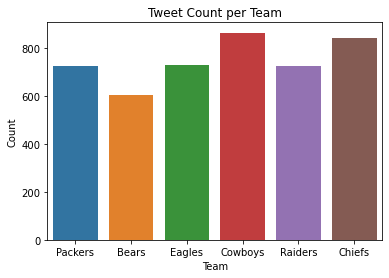

In [55]:
#check to make sure the number of tweets per team remains similar 
ax = sns.countplot(x = "team", data=football_feed_df)
ax.set(title = "Tweet Count per Team", xlabel = "Team", ylabel = "Count")
plt.show()

In [56]:
#shuffle the data 
np.random.seed(1)
df = football_feed_df.reindex(np.random.permutation(football_feed_df.index))

In [57]:
import re
contraction_patterns=[(r'can\'t', 'cannot'),
                    (r'haven\'t', 'have not'),
                    (r'(\w+)\'ll', '\g<1> will'),
                    (r'(\w+)\'re', '\g<1> are'),
                     (r'(\w+)\'ve', '\g<1> have'), 
                     (r'don\'t', 'do not')]

class contraction_replacer(object):
    def __init__(self, contraction_patterns):        
        # store compiled regex object
        self._contraction_regexes = [(re.compile(p), replaced_text) for p, replaced_text in contraction_patterns]
        
    def do_contraction_normalization(self, text):
        for contraction_regex, replaced_text in self._contraction_regexes:
            text = contraction_regex.sub(replaced_text, text)
        return text     
contraction_replacer = contraction_replacer(contraction_patterns)

In [58]:
def clean_tweet(tweet):
    btweet = contraction_replacer.do_contraction_normalization(tweet)
    wnetl = WordNetLemmatizer()
    ctweet = wnetl.lemmatize(btweet)
    word_regex= nltk.RegexpTokenizer(pattern=r'\w+', gaps=False)
    clean_tweet = word_regex.tokenize(ctweet)
    stopwords = nltk.corpus.stopwords.words('english')
    stop_clean_sent = [w for w in clean_tweet if w not in stopwords]
    return stop_clean_sent 

In [59]:
football_feed_df["full_text"] = football_feed_df["full_text"].apply(str)
clean_football_tweets = football_feed_df["full_text"].apply(clean_tweet)
football_feed_df['tokens'] = football_feed_df["full_text"].apply(clean_tweet)
football_feed_df["text length"] = clean_football_tweets.apply(len)

clean_football_tweets[0:3]

0    [Thinking, many, Iowa, meat, packers, voted, Bernie, would, given, ownership, stake, business, greater, control, conditions, Medicare, All]
1                                                                             [Packers, WR, Davante, Adams, practice, today, due, ankle, injury]
2                  [Packers, WR, Davante, Adams, officially, injury, report, play, Sunday, Colts, WR, Allen, Lazard, core, listed, questionable]
Name: full_text, dtype: object

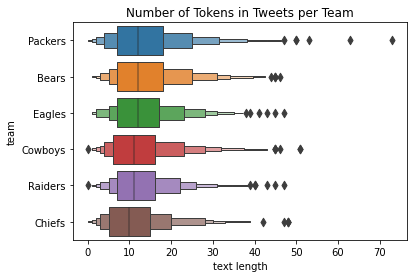

In [60]:
ax = sns.boxenplot(x=football_feed_df["text length"], y = football_feed_df["team"])
ax.set(title = "Number of Tokens in Tweets per Team")
plt.show()

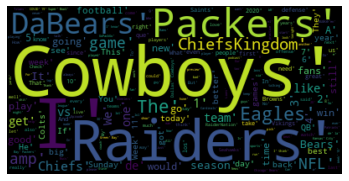

In [61]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

unique_string=(" ").join(map(str, clean_football_tweets))
wordcloud = WordCloud().generate(unique_string)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


plt.show()

Packers


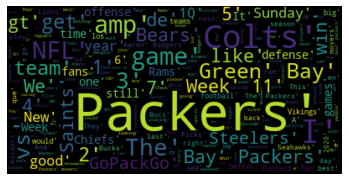

Bears


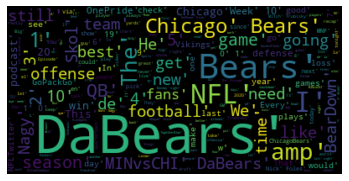

Eagles


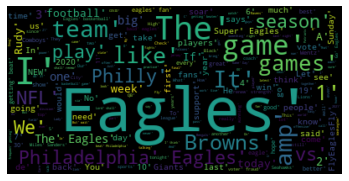

Cowboys


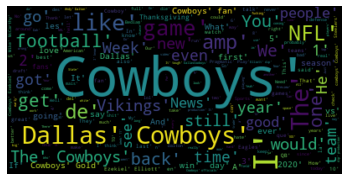

Raiders


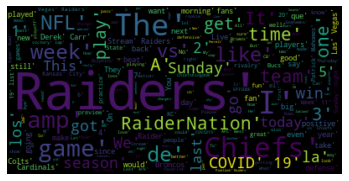

Chiefs


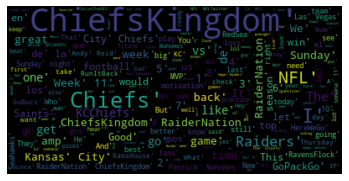

In [62]:
teams = ["Packers","Bears","Eagles", "Cowboys","Raiders", "Chiefs"]

for i in range(len(teams)):
    df = football_feed_df[football_feed_df['team']==teams[i]]
    print(teams[i])
    unique_string=(" ").join(map(str, df.tokens))
    wordcloud = WordCloud().generate(unique_string)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")


    plt.show()

# Naive Bayes Classifier

In [63]:
from nltk.corpus import twitter_samples

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens) 
        
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')

In [64]:
clean_positive = pd.Series(positive_tweets).apply(clean_tweet)
clean_negative = pd.Series(negative_tweets).apply(clean_tweet)

nb_positive = get_tweets_for_model(clean_positive)
nb_negative = get_tweets_for_model(clean_negative)


In [65]:
clean_positive[:3]

0              [FollowFriday, France_Inte, PKuchly57, Milipol_Paris, top, engaged, members, community, week]
1    [Lamb2ja, Hey, James, How, odd, Please, call, Contact, Centre, 02392441234, able, assist, Many, thanks]
2                     [DespiteOfficial, listen, last, night, As, You, Bleed, amazing, track, When, Scotland]
dtype: object

In [66]:
nb_positive_dataset = [(tweet_dict, 1)
                     for tweet_dict in nb_positive]

nb_negative_dataset = [(tweet_dict, 0)
                     for tweet_dict in nb_negative]

nb_dataset = positive_dataset + negative_dataset
random.shuffle(nb_dataset)

nb_train_data = nb_dataset[:7000]
nb_test_data = nb_dataset[7000:]


In [67]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = nltk.NaiveBayesClassifier.train(nb_train_data)

print("Accuracy is:", classify.accuracy(classifier, nb_test_data))

#print(classifier.show_most_informative_features(10))

Accuracy is: 0.7783333333333333


In [19]:
from sklearn.metrics import accuracy_score, zero_one_loss, classification_report, confusion_matrix, plot_confusion_matrix, recall_score, precision_score, f1_score, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.anova import anova_lm
from lightgbm.sklearn import LGBMClassifier
from sklearn.svm import SVC

# Try Random Forest, K Nearest Neighbors, etc.
param_grid = {"max_depth":range(1,18), 
"max_features":[0.2, 0.4, 0.6, 0.8]}
svm_param_grid = {"gamma" : ['scale', 'auto'], "C":[i for i in np.arange(0.1, 1, 0.1)]}
knn_param_grid = {"n_neighbors":[k for k in range(1,25)],"weights":["uniform", "distance"]}
gbm_grid = dict()
gbm_grid['n_estimators'] = [10, 50, 100, 500]
gbm_grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
gbm_grid['subsample'] = [0.5, 0.7, 1.0]
gbm_grid['max_depth'] = [3, 7, 9]

# Initialize Estimators
clf = DecisionTreeClassifier()
rf = RandomForestClassifier()
svc = SVC()
knn = KNeighborsClassifier()
gbm = GradientBoostingClassifier()

# Initialize Grid Searchers
gridsearch_clf = GridSearchCV(clf, param_grid, cv = 8, n_jobs = -1)
gridsearch_rf = GridSearchCV(rf, param_grid, cv = 8, n_jobs = -1)
gridsearch_svc = GridSearchCV(svc, svm_param_grid, cv = 8, n_jobs = -1)
gridsearch_knn = GridSearchCV(knn, knn_param_grid, cv = 8, n_jobs = -1)
gridsearch_gbm = GridSearchCV(gbm, gbm_grid, cv = 8, n_jobs = -1)

# Fit the models
gridsearch_clf.fit(train_data, test_data)
gridsearch_rf.fit(train_data, test_data)
gridsearch_svc.fit(train_data, test_data)
gridsearch_knn.fit(train_data, test_data)
gridsearch_gbm.fit(train_data, test_data)

TypeError: '<' not supported between instances of 'int' and 'dict'

In [68]:
football_clean = get_tweets_for_model(clean_football_tweets)

football_dat = [(tweet_dict)
                     for tweet_dict in football_clean]

In [69]:
classifier.classify(football_dat[0])

#Classify each tweet one by one (not a vectorized process)
sentiment = []
for tweet in football_dat:
    s = classifier.classify(tweet)
    sentiment.append(s)

football_feed_df['sentiment'] = sentiment

In [70]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

football_feed_df[['full_text', 'sentiment']]



,full_text,sentiment
0,"Thinking about how many Iowa meat packers voted for Bernie who would’ve given them ownership stake in their business, greater control over their conditions, and Medicare for All.",1
1,Packers' WR Davante Adams did not practice today due to an ankle injury.,0
2,"#Packers WR Davante Adams is officially off the injury report and will play Sunday against the #Colts, while WR Allen Lazard (core) is listed as questionable.",1
3,"Highlights are the #ALR &amp; BC Food Security, including the KPU Farm School on the Garden City Lands. Then #RichmondBC Garry Point &amp; Terra Nova Parks, Trails, Gulf of Georgia Cannery &amp; Britannia Shipyard. On the down side loss of BC Packers Cannery for a seafood market &amp; #SiteC Dam",1
4,"The Packers have Rodgers \n\nThe Brewers have Yelich\n\nThe Bucks have Giannis \n\nI am a Wisconsin sports fan asking, once agai…",1
...,...,...
4495,I'm almost more concerned about the Dolphins game this season than the Saints.,0
4496,Early days I know but if Miami drafts well (&amp; they’ve got ALOT of picks coming up) they could be a problem in the A…,0
4497,Chase Young. Didn’t hear his name all game.....until his late hit.,0
4498,Chase Young...... why?!,1


## Read in Journalism Scrape

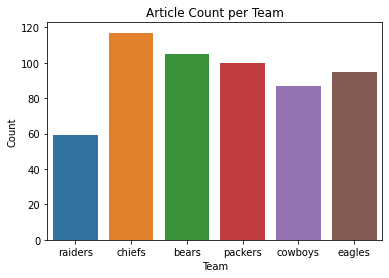

In [71]:
football_articles = pd.read_csv('sports_journalism.csv') #row 15 has text NAN
football_articles.isna().sum()

football_articles.dropna(subset=['Text'], inplace=True)
football_articles.isna().sum()#make sure there are no nans in txt or team 

#make sure team counts roughly even 
#check to make sure the number of tweets per team remains similar 
ax = sns.countplot(x = "Team", data=football_articles)
ax.set(title = "Article Count per Team", xlabel = "Team", ylabel = "Count")
plt.show()

In [72]:
#preprocess article text
article_tokens = football_articles["Text"].apply(clean_tweet)
football_articles["tokens"] = football_articles["Text"].apply(clean_tweet)
clean_article = get_tweets_for_model(article_tokens)

article_dat = [(art_dict)
                     for art_dict in clean_article]
#article_dat[0:3]

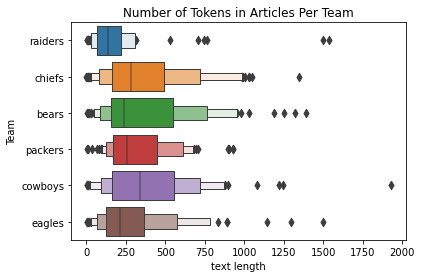

In [73]:
football_articles["text length"] = article_tokens.apply(len)
ax = sns.boxenplot(x=football_articles["text length"], y = football_articles["Team"])
ax.set(title = "Number of Tokens in Articles Per Team")
plt.show()

raiders


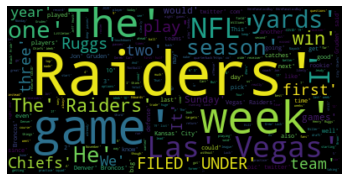

chiefs


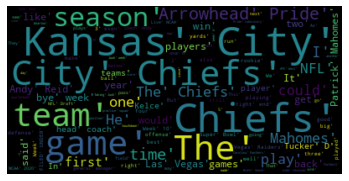

bears


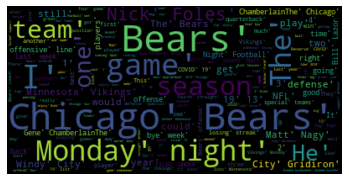

packers


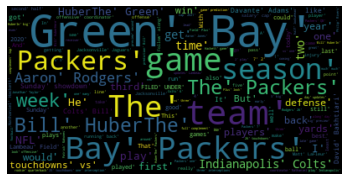

cowboys


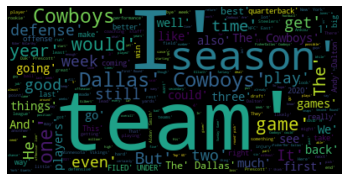

eagles


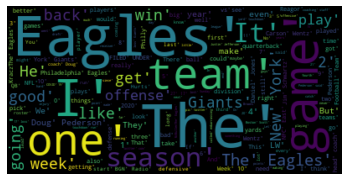

In [74]:
teams = ['raiders', 'chiefs', 'bears', 'packers', 'cowboys', 'eagles']

for i in range(len(teams)):
    df = football_articles[football_articles['Team']==teams[i]]
    print(teams[i])
    unique_string=(" ").join(map(str, df.tokens))
    wordcloud = WordCloud().generate(unique_string)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    plt.show()

In [75]:
sentiment = []
for a in article_dat:
    s = classifier.classify(a)
    sentiment.append(s)

football_articles['sentiment'] = sentiment

In [76]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 50)

football_articles[['Text', 'sentiment']]

,Text,sentiment
0,Chiefs coach Andy Reid addresses the Raiders' ...,1
1,Patrick Mahomes is announced as a member of th...,1
2,Chicago native Michael Wilbon says Theo Epstei...,1
3,"GREEN BAY, Wis. -- It's not Marquez Valdes-Sca...",0
4,"FRISCO, Texas -- As the country experiences a ...",0
...,...,...
559,Just as we thought the Kansas City Chiefs were...,1
560,Tucker D. FranklinWhile there are many Kansas ...,1
561,Chiefs Chairman and CEO Clark Hunt's decision ...,1
562,TNS. FNLWatch!! Eifel Grand Prix Live Online: ...,1


In [77]:
##combine the sources 
football_feed_df['source'] = ['Twitter' for r in range(len(football_feed_df))]
football_articles['source'] = ['Web Article' for r in range(len(football_articles))]

football_articles.rename(columns={'Team': 'team', 'Text': 'full_text'}, inplace=True)
football_articles['team'] = football_articles['team'].str.capitalize()
total_df = pd.concat([football_feed_df[['full_text', 'team', 'source', 'sentiment']], football_articles[['full_text', 'team', 'source', 'sentiment']]])

print(total_df['team'].value_counts())

total_df

Chiefs     959
Cowboys    953
Packers    828
Eagles     828
Raiders    784
Bears      710
Name: team, dtype: int64


,full_text,team,source,sentiment
0,Thinking about how many Iowa meat packers vote...,Packers,Twitter,1
1,Packers' WR Davante Adams did not practice tod...,Packers,Twitter,0
2,#Packers WR Davante Adams is officially off th...,Packers,Twitter,1
3,Highlights are the #ALR &amp; BC Food Security...,Packers,Twitter,1
4,The Packers have Rodgers \n\nThe Brewers have...,Packers,Twitter,1
...,...,...,...,...
559,Just as we thought the Kansas City Chiefs were...,Chiefs,Web Article,1
560,Tucker D. FranklinWhile there are many Kansas ...,Chiefs,Web Article,1
561,Chiefs Chairman and CEO Clark Hunt's decision ...,Chiefs,Web Article,1
562,TNS. FNLWatch!! Eifel Grand Prix Live Online: ...,Chiefs,Web Article,1


In [78]:
df_team_and_source = pd.DataFrame(total_df.groupby(['team', 'source'])['sentiment'].mean()).reset_index()
df_team = pd.DataFrame(df_team_and_source.groupby('team')['sentiment'].mean()).reset_index() #averages twitter and article sentiment
df_team

,team,sentiment
0,Bears,0.772373
1,Chiefs,0.785416
2,Cowboys,0.682295
3,Eagles,0.675666
4,Packers,0.756236
5,Raiders,0.680269


team
Bears      0.712676
Chiefs     0.700730
Cowboys    0.572928
Eagles     0.669082
Packers    0.677536
Raiders    0.639031
Name: sentiment, dtype: float64

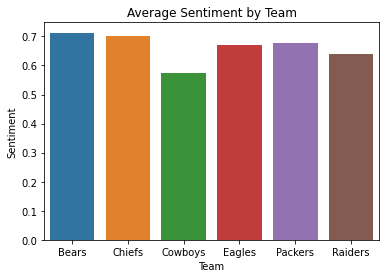

In [79]:
#group by teams
fig, ax = plt.subplots()
df_team = pd.DataFrame(total_df.groupby('team')['sentiment'].mean()).reset_index()
ax = sns.barplot(x = "team", y = "sentiment", data = df_team)
ax.set(title="Average Sentiment by Team", 
        xlabel="Team",
        ylabel="Sentiment")
total_df.groupby('team')['sentiment'].mean()

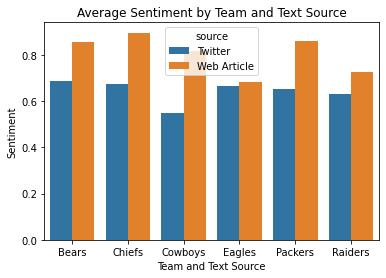

In [80]:
fig, ax = plt.subplots()
df_team_and_source = pd.DataFrame(total_df.groupby(['team', 'source'])['sentiment'].mean()).reset_index()
ax = sns.barplot(x = "team", hue = "source", y = "sentiment", data = df_team_and_source)
ax.set(title="Average Sentiment by Team and Text Source", 
        xlabel="Team and Text Source",
        ylabel="Sentiment")
plt.show()
#total_df.groupby(['team', 'source'])['sentiment'].mean()

source
Twitter        0.640142
Web Article    0.817052
Name: sentiment, dtype: float64

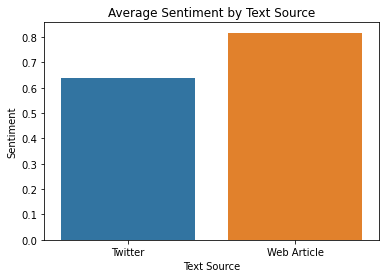

In [81]:
fig, ax = plt.subplots()
df_source = pd.DataFrame(total_df.groupby(['source'])['sentiment'].mean()).reset_index()
ax = sns.barplot(x = "source", y = "sentiment", data = df_source)
ax.set(title="Average Sentiment by Text Source", 
        xlabel="Text Source",
        ylabel="Sentiment")
total_df.groupby(['source'])['sentiment'].mean()